In [12]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import os

In [13]:
# Config
subject_number = 217
input_file = f"./input/mediapipe/{subject_number}/{subject_number}_side_video_landmarks.json"
outputdir = f"./output/{subject_number}"
output_file = f"./output/{subject_number}/{subject_number}_side_2_gait_cycles.json"

fps = 30.0

landmarks = {
    0: "Nose", 1: "Left_Eye_Inner", 2: "Left_Eye", 3: "Left_Eye_Outer",
    4: "Right_Eye_Inner", 5: "Right_Eye", 6: "Right_Eye_Outer",
    7: "Left_Ear", 8: "Right_Ear", 9: "Mouth_Left", 10: "Mouth_Right",
    11: "Left_Shoulder", 12: "Right_Shoulder", 13: "Left_Elbow", 14: "Right_Elbow",
    15: "Left_Wrist", 16: "Right_Wrist", 17: "Left_Pinky", 18: "Right_Pinky",
    19: "Left_Index", 20: "Right_Index", 21: "Left_Thumb", 22: "Right_Thumb",
    23: "Left_Hip", 24: "Right_Hip", 25: "Left_Knee", 26: "Right_Knee",
    27: "Left_Ankle", 28: "Right_Ankle", 29: "Left_Heel", 30: "Right_Heel",
    31: "Left_Foot_Index", 32: "Right_Foot_Index"
}

landmark_index = 30
landmark_name = landmarks[landmark_index]

os.makedirs(outputdir, exist_ok=True)

In [14]:
# Load and rewrite files to exclude none and null values
with open(input_file, "r") as f:
  data = json.load(f)

data['landmarks_data'] = [frame for frame in data['landmarks_data'] if (frame['pose_landmarks'] is not None)]

with open(input_file, 'w') as outfile:
  json.dump(data, outfile, indent=4)

In [15]:
# Load mediapipe data
with open(input_file, "r") as f:
    data = json.load(f)   
    
frames = data["landmarks_data"]
points = []
for frame in frames:
    if "pose_landmarks" in frame and frame["pose_landmarks"]:
        arr = np.array(frame["pose_landmarks"])[:, :3]
        points.append(arr)
    else:
        points.append(None)

In [16]:
def smooth_pose_butter(poses, cutoff=3, fs=30, order=4):
    """
    cutoff: cutoff frequency (Hz)
    fs: sample rate (frames per second)
    order: filter order
    """
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    smoothed = np.copy(poses)
    for j in range(poses.shape[1]):
        for k in range(3):
            smoothed[:, j, k] = filtfilt(b, a, poses[:, j, k])
    return smoothed

In [17]:
# Compute velocity via 3d distance formula
points = smooth_pose_butter(np.array(points), fs=fps, order=4)

velocity = []
for i in range(len(points) - 1):
    if points[i] is None or points[i + 1] is None:
        continue
    p1 = points[i][landmark_index]
    p2 = points[i + 1][landmark_index]
    d = math.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2) + ((p2[2] - p1[2]) ** 2))
    velocity.append(d)

In [18]:
# Compute velocity and acceleration 
dt = 1.0 / fps
acceleration = np.gradient(velocity, dt)
time = np.arange(len(velocity)) / fps

velocity_smooth = gaussian_filter1d(velocity, sigma=8)
acceleration_smooth = gaussian_filter1d(acceleration, sigma=8)

Using height: 0.006914888101979684


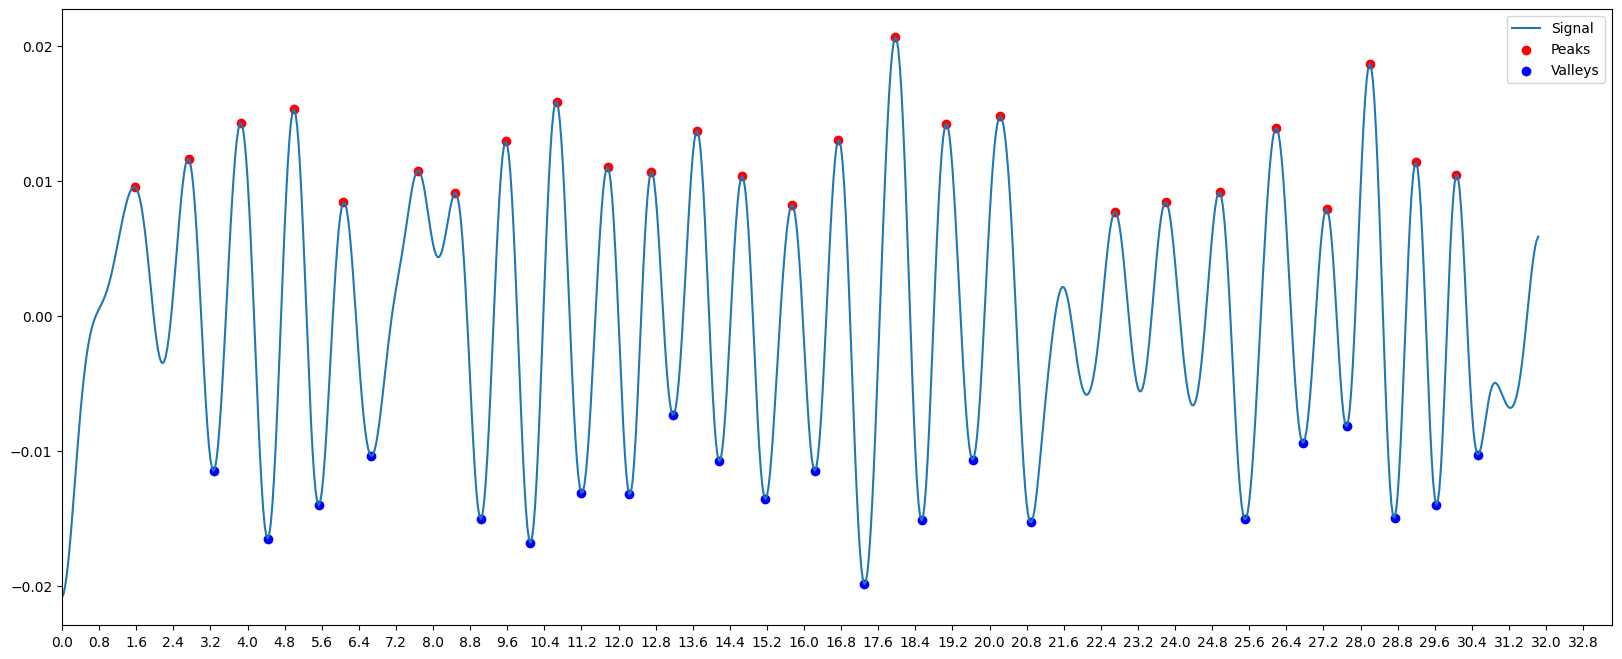

In [19]:
# Find and plot acceleration peaks and valleys
height = abs(np.percentile(acceleration_smooth, 25))
print(f"Using height: {height}")
peaks, props = find_peaks(acceleration_smooth, height=height, distance=5)
valleys, props_v = find_peaks(-acceleration_smooth, height=height, distance=5)

plt.figure(figsize=(20, 8))
plt.plot(time, acceleration_smooth, label='Signal')
plt.scatter(time[peaks], acceleration_smooth[peaks], color='red', label='Peaks')
plt.scatter(time[valleys], acceleration_smooth[valleys], color='blue', label='Valleys')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=50))
plt.xlim(left=0)
plt.legend()
plt.savefig(f'{outputdir}/{subject_number}-cycles.png')
plt.show()

In [20]:
counter = 1
for heel_strike in valleys:
  print(f"Heel Strike {counter}: {heel_strike} at {time[heel_strike]}")
  counter = counter + 1


Heel Strike 1: 98 at 3.2666666666666666
Heel Strike 2: 133 at 4.433333333333334
Heel Strike 3: 166 at 5.533333333333333
Heel Strike 4: 200 at 6.666666666666667
Heel Strike 5: 271 at 9.033333333333333
Heel Strike 6: 303 at 10.1
Heel Strike 7: 336 at 11.2
Heel Strike 8: 367 at 12.233333333333333
Heel Strike 9: 395 at 13.166666666666666
Heel Strike 10: 425 at 14.166666666666666
Heel Strike 11: 455 at 15.166666666666666
Heel Strike 12: 487 at 16.233333333333334
Heel Strike 13: 519 at 17.3
Heel Strike 14: 556 at 18.533333333333335
Heel Strike 15: 589 at 19.633333333333333
Heel Strike 16: 627 at 20.9
Heel Strike 17: 765 at 25.5
Heel Strike 18: 803 at 26.766666666666666
Heel Strike 19: 831 at 27.7
Heel Strike 20: 862 at 28.733333333333334
Heel Strike 21: 889 at 29.633333333333333
Heel Strike 22: 916 at 30.533333333333335


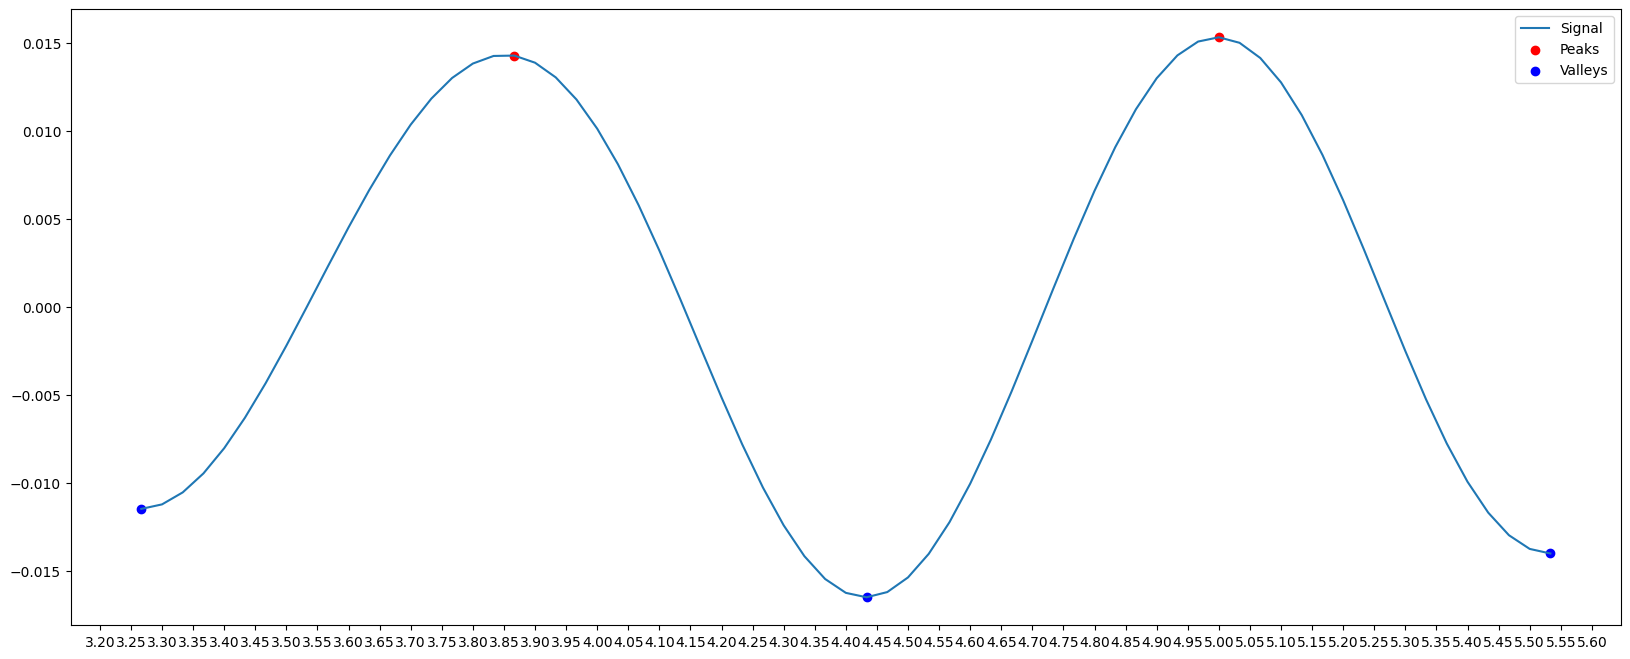

In [21]:
first_heel_strike = valleys[0]
third_heel_strike = valleys[2]

first_heel_strike_time = time[first_heel_strike]
third_heel_strike_time = time[third_heel_strike]

crop_data = acceleration_smooth[first_heel_strike : third_heel_strike + 1]
crop_time = time[first_heel_strike : third_heel_strike + 1]
crop_peaks = [peak - first_heel_strike for peak in peaks if (peak >= first_heel_strike and peak <= third_heel_strike)]
crop_valleys = [valley - first_heel_strike for valley in valleys if (valley >= first_heel_strike and valley <= third_heel_strike)]

plt.figure(figsize=(20, 8))
plt.plot(crop_time, crop_data, label='Signal')
plt.scatter(crop_time[crop_peaks], crop_data[crop_peaks], color='red', label='Peaks')
plt.scatter(crop_time[crop_valleys], crop_data[crop_valleys], color='blue', label='Valleys')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=50))
plt.legend()
plt.savefig(f'{outputdir}/{subject_number}-cycles-trimmed.png')
plt.show()

In [22]:
# Export cropped 2 gait cycles back to mediapipe landmarks
newdata = {}
with open(input_file, "r") as f:
  new_data = json.load(f)

new_data['landmarks_data'] = new_data['landmarks_data'][first_heel_strike - 1 : third_heel_strike]
with open(output_file, 'w') as f:
  json.dump(new_data, f, indent=4)

print(f'Wrote 2 gait cycles clipped to {output_file}')

Wrote 2 gait cycles clipped to ./output/217/217_side_2_gait_cycles.json
